In [4]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import random

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
TRAIN_PATH = '/content/drive/MyDrive/stage1_train/'
TEST_PATH = '/content/drive/MyDrive/stage1_test/'

print("Train Path Exists:", os.path.exists(TRAIN_PATH))
print("Test Path Exists:", os.path.exists(TEST_PATH))

Train Path Exists: True
Test Path Exists: True


In [6]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')







Resizing training images and masks


100%|██████████| 670/670 [1:44:52<00:00,  9.39s/it]


Resizing test images


100%|██████████| 65/65 [00:29<00:00,  2.23it/s]

Done!


In [9]:
np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Y_train.npy', Y_train)
np.save('/content/drive/MyDrive/X_test.npy', X_test)


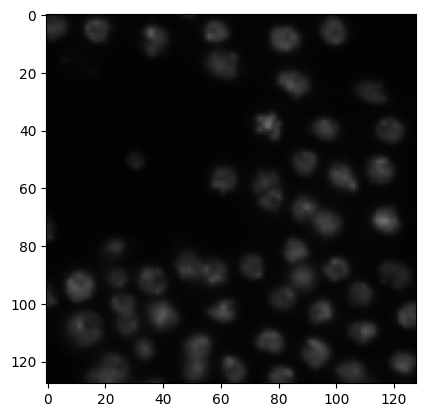

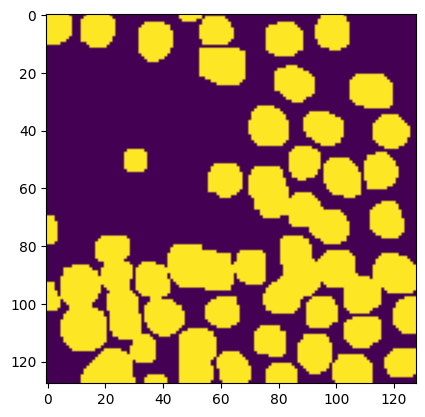

In [19]:
import random
image_x = random.randint(0, len(train_ids))
plt.imshow(X_train[image_x])
plt.show()
plt.imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print((Y_train[image_x]).shape)


(670, 128, 128, 3)
(670, 128, 128, 1)
(65, 128, 128, 3)
(128, 128, 1)


In [21]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Now begins the expansive path of the 'U'
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis=3)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid', kernel_initializer='he_normal', padding='same')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)
callbacks = [
    checkpointer,
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 128, 128, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 128, 128, 16)   │              0 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 16)     │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64, 64, 32)     │              0 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ dropout_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 32, 32, 64)     │              0 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 16, 16, 128)    │              0 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11     

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7548 - loss: 0.6285
Epoch 1: val_loss improved from inf to 0.37976, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.7549 - loss: 0.6269 - val_accuracy: 0.7673 - val_loss: 0.3798
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8170 - loss: 0.3273
Epoch 2: val_loss improved from 0.37976 to 0.33495, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8179 - loss: 0.3265 - val_accuracy: 0.8632 - val_loss: 0.3350
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9204 - loss: 0.2182
Epoch 3: val_loss improved from 0.33495 to 0.16746, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9206 - loss: 0.2178 - val_accuracy: 0.9386 - val_loss: 0.1675
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9419 - loss: 0.1563
Epoch 4: val_loss did not improve from 0.16746
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9420 - loss: 0.1561 - val_accuracy: 0.9368 - val_loss: 0.1710
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9416 - loss: 0.1557
Epoch 5: val_loss improved from 0.16746 to 0.13263, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9418 - loss: 0.1553 - val_accuracy: 0.9485 - val_loss: 0.1326
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9519 - loss: 0.1256
Epoch 6: val_loss improved from 0.13263 to 0.12173, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9519 - loss: 0.1256 - val_accuracy: 0.9529 - val_loss: 0.1217
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9511 - loss: 0.1269
Epoch 7: val_loss did not improve from 0.12173
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9512 - loss: 0.1267 - val_accuracy: 0.9521 - val_loss: 0.1302
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9563 - loss: 0.1127
Epoch 8: val_loss did not improve from 0.12173
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9563 - loss: 0.1127 - val_accuracy: 0.9530 - val_loss: 0.1271
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9598 - loss: 0.1030
Epoch 9: val_loss improved from 0.12173 to 0.10753, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9598 - loss: 0.1031 - val_accuracy: 0.9581 - val_loss: 0.1075
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9600 - loss: 0.1045
Epoch 10: val_loss improved from 0.10753 to 0.10422, saving model to model_for_nuclei.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9600 - loss: 0.1046 - val_accuracy: 0.9604 - val_loss: 0.1042
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9608 - loss: 0.1040
Epoch 11: val_loss did not improve from 0.10422
38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9608 - loss: 0.1040 - val_accuracy: 0.9593 - val_loss: 0.1068
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9630 - loss: 0.0962
Epoch 12: val_loss did not improve from 0.10422
38/38 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9630 - loss: 0.0963 - val_accuracy: 0.9605 - val_loss: 0.1063
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9629 - loss: 0.0961
Epoch 13: val_loss did not improve from 0.10422
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9629 - loss: 0.0962 - val_accuracy: 0.9604 - val_loss: 0.1053


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_88']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 622ms/step


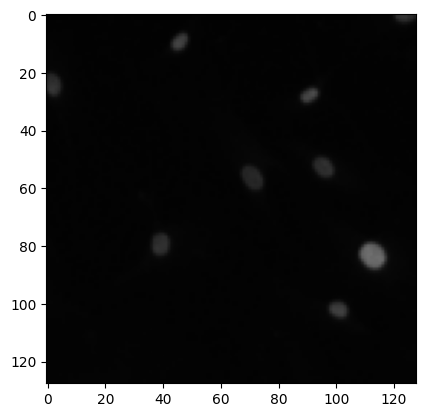

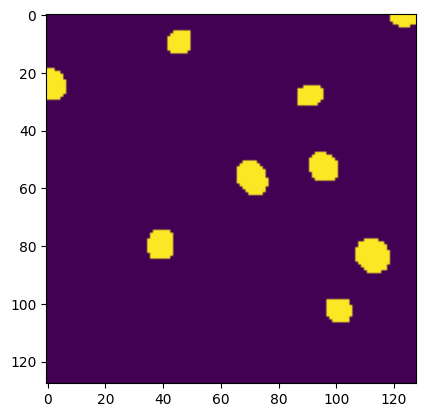

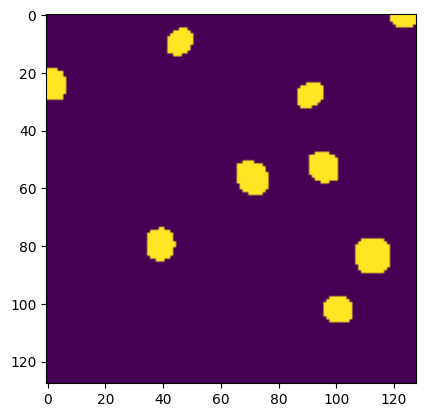

In [22]:
idx = random. randint(0, len(X_train))
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test = (preds_test > 0.5).astype(np.uint8)


ix = random.randint(0, len(preds_train_t))
plt.imshow(X_train[ix])
plt.show()

plt.imshow(np.squeeze(Y_train[ix]))
plt.show()

plt.imshow(np.squeeze(preds_train_t[ix]))





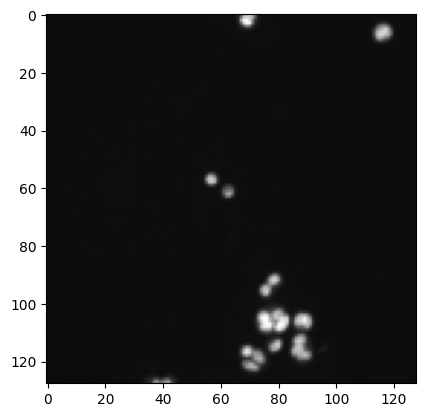

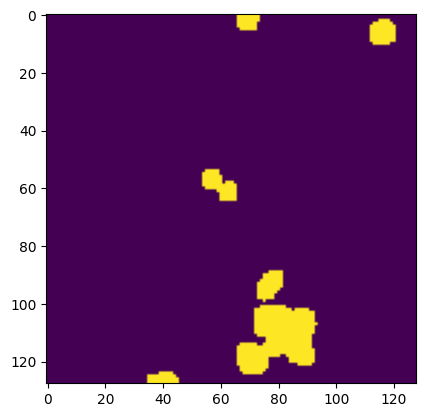

In [37]:
tx = random.randint(0, len(preds_test))
plt.imshow(X_test[tx])
plt.show()

plt.imshow(np.squeeze(preds_test[tx]))
plt.show()
